In [2]:
import numpy as np
import torch
from torch import nn
import torchaudio 
import os
import matplotlib.pyplot as plt
import librosa

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from IPython.display import Audio

os.environ['CUDA_LAUNCH_BLOCKING']="1"

### Exploring data

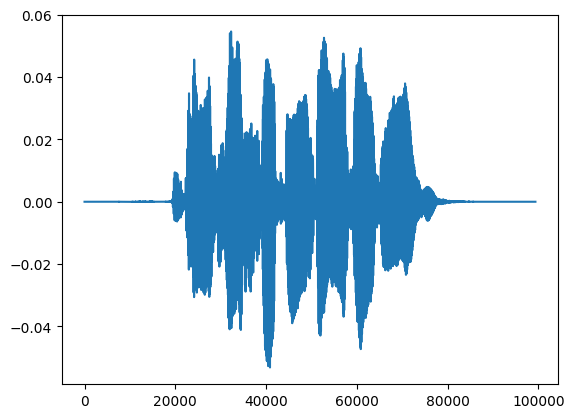

In [ ]:
url = "./data/song_actors/Actor_01/03-02-02-01-02-01-01.wav"
sig, sr = librosa.load(url)
plt.plot(sig)
Audio(sig,rate=sr)

Different features can be extracted from audio which can be utilized for training a model. From trial and error and for sake of simiplicity only mfcc is choosen to be used 

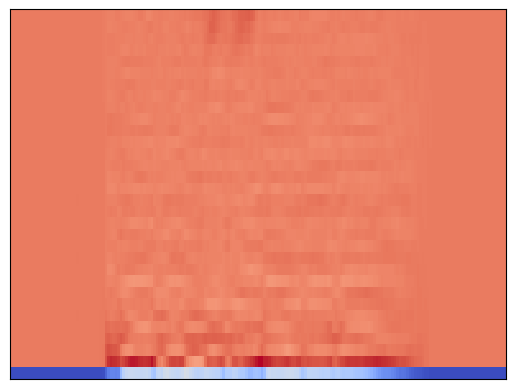

In [73]:
mfcc = librosa.feature.mfcc(y=sig,sr=sr, n_fft=2048, hop_length=512, n_mfcc=32)
librosa.display.specshow(mfcc)

### Getting data

In [4]:
# getting all labels and URLs of audio files 
labels = []
URLs = []

dataURL = './data/'
vocals = ['song_actors','speech_actors']

for type in vocals:
    for actor in os.listdir(dataURL + type):
        labels += [int(audio.split('-')[2])-1 for audio in os.listdir(dataURL + type + '/' + actor)]
        URLs += [dataURL + type + '/' + actor + '/' + audio for audio in os.listdir(dataURL + type + '/' + actor)]

labels = np.array(labels)
URLs = np.array (URLs)

# stratified 80/20 trian test split
trainIdx, valIdx = train_test_split(np.arange(len(URLs)),random_state=111,train_size=0.8,shuffle=True,stratify=labels)

verifying stratified split

<BarContainer object of 8 artists>

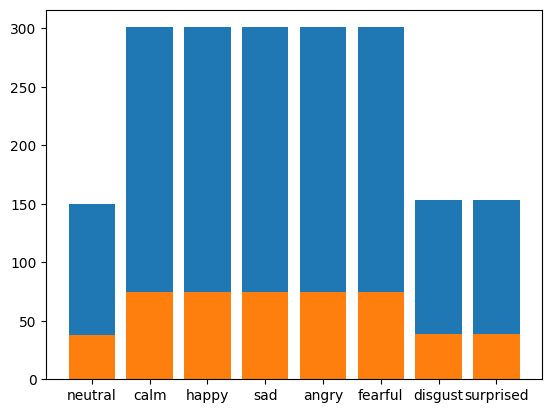

In [10]:
emotions = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

plt.bar(emotions, np.unique_counts(labels[trainIdx])[1])
plt.bar(emotions, np.unique_counts(labels[valIdx])[1])

In [ ]:
# function to get features from URL
def transform_pipeline(url, augParam, train=True):
    sig, sr = librosa.load(url,duration=3,offset=0.9)

    # clipping to const duration
    maxSamples = 3*sr 
    n = len(sig)
    if (n > maxSamples):
        sig = sig[:maxSamples]
    elif (n < maxSamples):
        padding = np.zeros(maxSamples-n)
        sig = np.concat((sig,padding))

    # augementation for train dataset
    # time shift
    if (train and 'timeStd' in augParam.keys()):
        randomShift = int(np.random.normal()*augParam['timeStd']*maxSamples)
        sig = np.roll(sig,randomShift)
    # noise augmentation
    if (train and 'noise' in augParam.keys()):
        sig = np.random.normal(size=len(sig))*augParam['noise']+sig

    # spectral 
    mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_fft=2048, hop_length=512, n_mfcc=32)
    features = torch.stack([torch.FloatTensor(mfcc)])
    return features


Creating train and validation datasets and dataloaders

In [ ]:
# custom dataset
class AudioData(torch.utils.data.Dataset):
    def __init__(self, train=True):
        idx = trainIdx if train else valIdx
        self.train = train
        self.URLs = URLs[idx]
        self.labels = labels[idx]                         
    
    def __getitem__(self,idx):
        audioURL = self.URLs[idx]
        features = transform_pipeline(audioURL,{}, train=self.train)
        return features, torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.URLs)

trainDS = AudioData(train=True)
valDS = AudioData(train=False)

trainLoader = torch.utils.data.DataLoader(trainDS,batch_size=64)
valLoader = torch.utils.data.DataLoader(valDS,batch_size=64)



In [ ]:
trainDS[1][0].shape

torch.Size([1, 32, 130])

## Training utils 

In [ ]:
def eval(model,dataLoader,device = 'cpu',criterion=nn.CrossEntropyLoss()):
    # model.to(device)
    model.eval()
    running_loss = 0
    running_acc = 0

    with torch.no_grad():

        for i, (features,labels) in enumerate(dataLoader):
            features = features.to(device)
            labels = labels.to(device)

            output = model(features)
            loss = criterion(output,labels)
            
            running_loss += loss.item()/len(labels)
            _,pred = torch.max(output,1)
            running_acc += (pred == labels).sum().item()/len(labels)
        
    return running_loss/len(dataLoader), running_acc/len(dataLoader)


def train(model, trainLoader, valLoader, num_epoches, learning_rate=0.03, scheduler_T_0=0, scheduler_T_mult=1, device='cpu', criterion=nn.CrossEntropyLoss()):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate,)
    
    # scheduler_T_0 - Number of iterations until the first restart for cosine annealing scheduler
    # if value is 0, use reduceLRonPlateau 
    if (scheduler_T_0):
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,scheduler_T_0,scheduler_T_mult,1e-6,)
    else:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=1)

    training_losses = []
    training_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoches):
        print (f'epoch {epoch}, lr {scheduler.get_last_lr()} :')
        model.train()

        running_loss = 0
        running_acc = 0

        for i, (features,labels) in enumerate(trainLoader):
            
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)

            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()/len(labels)
            _, preds = torch.max(outputs,1)
            running_acc += ((preds==labels).sum().item())/len(labels)

            if (i%10==9):
                print (f'\t batch : {i+1}, loss : {running_loss/(i+1) :.5f}, accuracy : {running_acc/(i+1) :.3f}')

        training_losses.append(running_loss/len(trainLoader))
        training_accuracies.append(running_acc/len(trainLoader))
        print (f'\n\t traning loss : {training_losses[-1]}, training accuracy : {training_accuracies[-1]}')

        eval_loss , eval_acc = eval(model, valLoader, device, criterion)
        val_losses.append(eval_loss)
        val_accuracies.append(eval_acc)
        print (f'\t validation loss : {eval_loss}, validation accuracy ; {eval_acc} \n')

        scheduler.step(epoch)

    return (training_losses ,training_accuracies), (val_losses,val_accuracies)

# Run on GPU if availaible
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
print (device,'-',torch.cuda.get_device_name())


cuda:0 - NVIDIA GeForce GTX 1650


In [ ]:
# # stratified k-fold cross validation
# def cross_validation(dataset, Model, num_epoches, batch_size, learning_rate=0.03,device='cpu'):
#     loader = torch.utils.data.DataLoader(dataset,batch_size=len(dataset),shuffle=False)
 

#     training_best = []
#     val_best = []

#     skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=49)
#     print (len(dataset))
#     print (len(labels))

#     for fold, (trainIdx, valIdx) in enumerate(skf.split(dataset,labels)):
#         print (f'fold : {fold}, train index : {len(trainIdx)}, val index : {len(valIdx)}')
        
#         model = Model()
#         trainDS = torch.utils.data.Subset(dataset, trainIdx)
#         valDS = torch.utils.data.Subset(dataset, valIdx)

#         trainLoader = torch.utils.data.DataLoader(trainDS,batch_size=batch_size)
#         valLoader = torch.utils.data.DataLoader(valDS,batch_size=batch_size)
#         # print (len(trainLoader))
#         # print (len(valLoader))

#         traning_result , val_result = train(model,trainLoader,valLoader,num_epoches,learning_rate,device)
        
#         training_best.append(np.max(traning_result[1]))
#         val_best.append(np.max(val_result[1]))

#     print (f'training : {training_best}, mean : {np.mean(training_best)}, std : {np.std(training_best)}')   
#     print (f'val : {val_best}, mean : {np.mean(val_best)}, std : {np.std(val_best)}')   


## Models

In [ ]:
# model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.act = nn.ReLU()
        self.pool = nn.AvgPool2d(2,2)
        # convolution layers
        self.conv1 = nn.Conv2d(1,8,3,1,1)
        self.bnorm1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8,16,3,1,1)
        self.bnorm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,16,3,1,1)
        self.bnorm3 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.2)
        # fully connected layer
        self.fc1 = nn.Linear(16*4*16,100)
        self.bnorm = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100,8)

    def forward(self, x):
        x = self.bnorm1(self.act(self.conv1(x)))
        x = self.pool(x)
        x = self.bnorm2(self.act(self.conv2(x)))
        x = self.pool(x)
        x = self.bnorm3(self.act(self.conv3(x)))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.dropout(x)
        x = self.bnorm(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x 
        
myModel = CNN()

In [ ]:
myModel = CNN() 
trainLog , valLog = train(myModel,trainLoader,valLoader, num_epoches=100, learning_rate=0.001,device=device)

In [ ]:
# model 2
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        # common layers
        self.act = nn.ReLU()
        self.pool = nn.AvgPool2d(2,2)
        # convolution layers
        self.conv1 = nn.Conv2d(1,8,3,1,1)
        self.bnorm1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8,16,3,1,1)
        self.bnorm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,32,3,1,1)
        self.bnorm3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32,16,3,1,1)
        self.bnorm4 = nn.BatchNorm2d(16)
        # fully connected layer
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16*2*8,8)

    def forward(self, x):
        x = self.bnorm1(self.act(self.conv1(x)))
        x = self.pool(x)
        x = self.bnorm2(self.act(self.conv2(x)))
        x = self.pool(x)
        x = self.bnorm3(self.act(self.conv3(x)))
        x = self.pool(x)
        x = self.bnorm4(self.act(self.conv4(x)))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x 
        
model2 = CNN2()

Using Cosine annealing lr scheduler with warm start periodically decreases the learing rate to a minimum value in a a quarter cosine wave form before beginning from high learning rate again (warm startup).

Periodically increaring helps the model escape shallower minimas and improve generalizability.

In [ ]:
# using cosine annealing scheduler
model2 = CNN2()
trainLog , valLog = train(model2,trainLoader,valLoader,100,learning_rate=0.001, scheduler_T_0=7, scheduler_T_mult=2, device=device)

epoch 0, lr [0.001] :
	 batch : 10, loss : 0.03098, accuracy : 0.216
	 batch : 20, loss : 0.03008, accuracy : 0.252
	 batch : 30, loss : 0.02905, accuracy : 0.278

	 traning loss : 0.02949025569575964, training accuracy : 0.2793813926042486
	 validation loss : 0.030482371906251755, validation accuracy ; 0.2701671511627907 

epoch 1, lr [0.001] :
	 batch : 10, loss : 0.02493, accuracy : 0.408
	 batch : 20, loss : 0.02462, accuracy : 0.400
	 batch : 30, loss : 0.02382, accuracy : 0.423

	 traning loss : 0.024240066236534238, training accuracy : 0.42315352084972463
	 validation loss : 0.024252256773802085, validation accuracy ; 0.449718386627907 

epoch 2, lr [0.0009505339495172585] :
	 batch : 10, loss : 0.02197, accuracy : 0.500
	 batch : 20, loss : 0.02145, accuracy : 0.510
	 batch : 30, loss : 0.02082, accuracy : 0.519

	 traning loss : 0.02126652188892209, training accuracy : 0.5182558025177026
	 validation loss : 0.021405173557658874, validation accuracy ; 0.5345657703488372 

epoch

KeyboardInterrupt: 

In [12]:
torch.save(model2.state_dict(),'best_model.pt')

Inference 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

testLoader = torch.utils.data.DataLoader(valDS,batch_size=len(valDS))
with torch.no_grad():
    model2.to('cpu')
    features, labels = next(iter(testLoader))
    features = features.to('cpu')
    labels = labels.to('cpu')
    outputs = model2(features)
    _,pred = torch.max(outputs,1)
    report = classification_report(labels,pred)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86        38
           1       0.84      0.89      0.86        75
           2       0.77      0.71      0.74        75
           3       0.69      0.69      0.69        75
           4       0.88      0.99      0.93        75
           5       0.74      0.72      0.73        75
           6       0.83      0.77      0.80        39
           7       0.84      0.67      0.74        39

    accuracy                           0.80       491
   macro avg       0.80      0.79      0.80       491
weighted avg       0.79      0.80      0.79       491



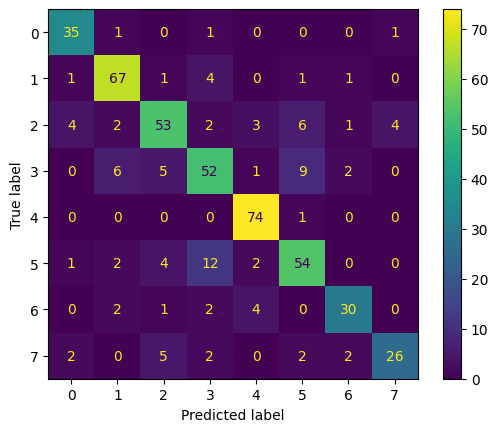

In [ ]:
mat = confusion_matrix(labels,pred)
ConfusionMatrixDisplay(mat).plot()
plt.show()

### Training without sad labels

In [ ]:
labels = []
URLs = []

dataURL = './data/'
vocals = ['song_actors','speech_actors']

for type in vocals:
    for actor in os.listdir(dataURL + type):
        labels += [int(audio.split('-')[2])-1 for audio in os.listdir(dataURL + type + '/' + actor)]
        URLs += [dataURL + type + '/' + actor + '/' + audio for audio in os.listdir(dataURL + type + '/' + actor)]

labels = np.array(labels)
URLs = np.array (URLs)

Obtaining URLs and Labels without sad label

In [ ]:
URLs = URLs[labels!=3]
labels = labels[labels!=3]

print (len(URLs),len(labels))

2076 2076


In [ ]:
# Stratified train test split
trainIdx, valIdx = train_test_split(np.arange(len(URLs)),random_state=111,train_size=0.8,shuffle=True,stratify=labels)

Creating train and validation datasets and dataloaders without sad labels

In [ ]:
trainDS = AudioData(train=True)
valDS = AudioData(train=False)

trainLoader = torch.utils.data.DataLoader(trainDS,batch_size=64)
valLoader = torch.utils.data.DataLoader(valDS,batch_size=64)

Retraining the model without sad labels and different lr scheduler hyper params 

In [ ]:
model2 = CNN2()
trainLog , valLog = train(model2,trainLoader,valLoader,50,learning_rate=0.001, scheduler_T_0=10, scheduler_T_mult=1 ,device=device)

epoch 0, lr [0.001] :
	 batch : 10, loss : 0.03049, accuracy : 0.228
	 batch : 20, loss : 0.02920, accuracy : 0.260

	 traning loss : 0.0285862300831538, training accuracy : 0.27912660256410254
	 validation loss : 0.032680467303310125, validation accuracy ; 0.2924107142857143 

epoch 1, lr [0.001] :
	 batch : 10, loss : 0.02367, accuracy : 0.452
	 batch : 20, loss : 0.02324, accuracy : 0.449

	 traning loss : 0.02285001649497411, training accuracy : 0.4656650641025641
	 validation loss : 0.023949712780969485, validation accuracy ; 0.5558035714285714 

epoch 2, lr [0.0009755527298894294] :
	 batch : 10, loss : 0.01945, accuracy : 0.555
	 batch : 20, loss : 0.01946, accuracy : 0.550

	 traning loss : 0.019073472979168095, training accuracy : 0.5651442307692307
	 validation loss : 0.020324215292930603, validation accuracy ; 0.6294642857142857 

epoch 3, lr [0.0009046039886902864] :
	 batch : 10, loss : 0.01702, accuracy : 0.611
	 batch : 20, loss : 0.01712, accuracy : 0.604

	 traning los

In [ ]:
# training for an extra epoch for good measures
train(model2,trainLoader,valLoader,1,learning_rate=9.639601130971382e-05,device=device)

epoch 0, lr [9.639601130971382e-05] :
	 batch : 10, loss : 0.00162, accuracy : 0.986
	 batch : 20, loss : 0.00171, accuracy : 0.984

	 traning loss : 0.001684933186819156, training accuracy : 0.9849358974358975
	 validation loss : 0.008011053848479475, validation accuracy ; 0.8348214285714286 



(([0.001684933186819156], [0.9849358974358975]),
 ([0.008011053848479475], [0.8348214285714286]))

Text(0.5, 1.0, 'accuracies')

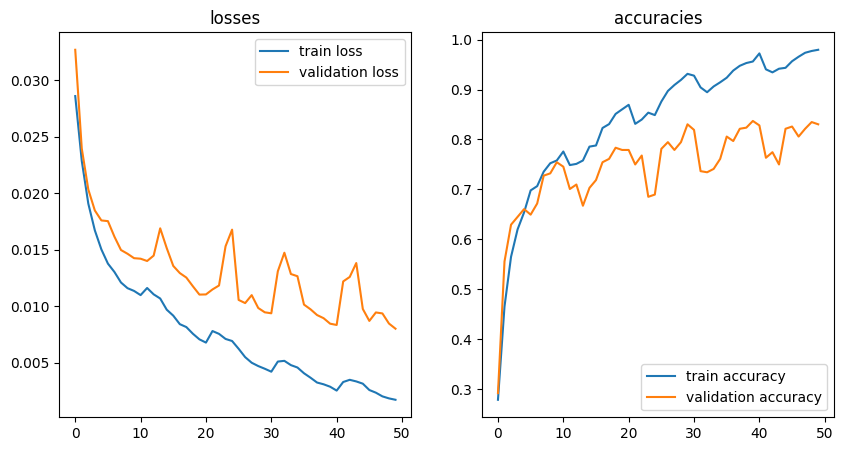

In [ ]:
# Plotting accuracyy and loss curves 
_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(trainLog[0],label='train loss')
ax[0].plot(valLog[0],label='validation loss')
ax[0].legend()
ax[0].set_title('losses')
ax[1].plot(trainLog[1],label='train accuracy')
ax[1].plot(valLog[1],label='validation accuracy')
ax[1].legend()
ax[1].set_title('accuracies')


In [ ]:
# saving the model
torch.save(model2.state_dict(),'sad_droped_model.pt')

Inference 

In [79]:
emotions = ['neutral','calm','happy','angry','fearful','disgust','surprised']

testLoader = torch.utils.data.DataLoader(valDS,batch_size=len(valDS))
with torch.no_grad():
    model2.to('cpu')
    features, labels = next(iter(testLoader))
    features = features.to('cpu')
    labels = labels.to('cpu')
    outputs = model2(features)
    _,pred = torch.max(outputs,1)
    report = classification_report(labels,pred,target_names=emotions)

In [80]:
print (report)

              precision    recall  f1-score   support

     neutral       0.74      0.97      0.84        38
        calm       0.96      0.87      0.91        75
       happy       0.77      0.68      0.72        75
       angry       0.87      0.88      0.87        75
     fearful       0.85      0.88      0.86        75
     disgust       0.76      0.74      0.75        39
   surprised       0.80      0.82      0.81        39

    accuracy                           0.83       416
   macro avg       0.82      0.83      0.82       416
weighted avg       0.83      0.83      0.83       416



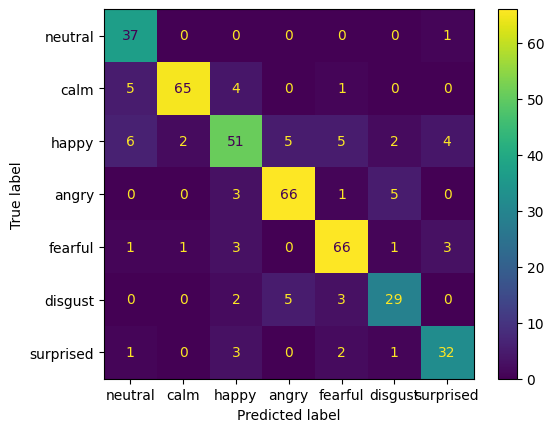

In [81]:
mat = confusion_matrix(labels,pred)
ConfusionMatrixDisplay(mat,display_labels=emotions).plot()
plt.show()

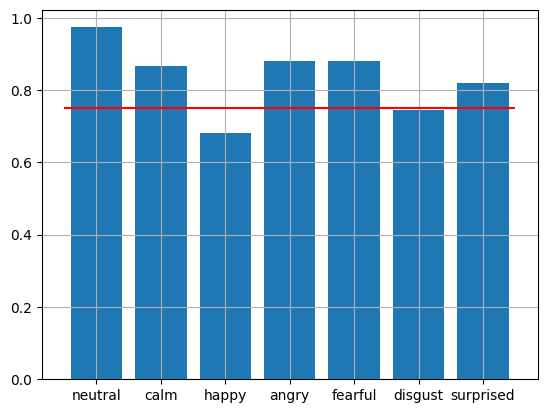

In [54]:
plt.grid(True)
plt.bar(['neutral','calm','happy','angry','fearful','disgust','surprised'],mat.diagonal()/mat.sum(axis=1))
plt.hlines(0.75,-0.5,6.5,colors='red')